In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 5fd22109-7e01-4065-9ca2-9a71dffe7c8e

In [2]:
import Local_NAV as local
from Global_NAV import *
import Motion_CTR_ as mctrl
import Kalman_FIL as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision2 import *

%matplotlib inline

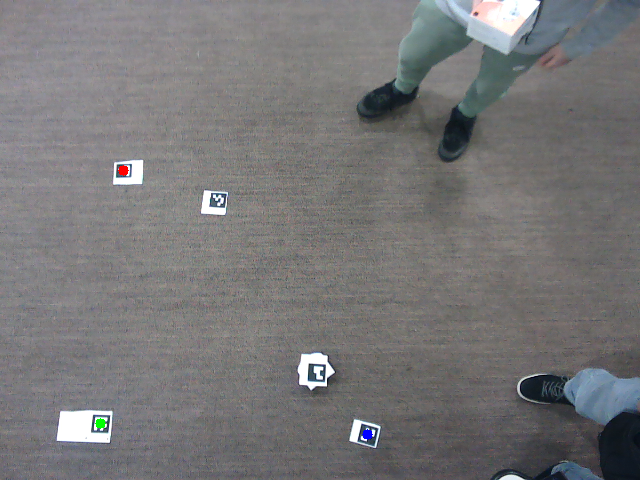

Thymio map pos [[788.67028494 235.87104006]]
Thymio map dir 3.079173843593836


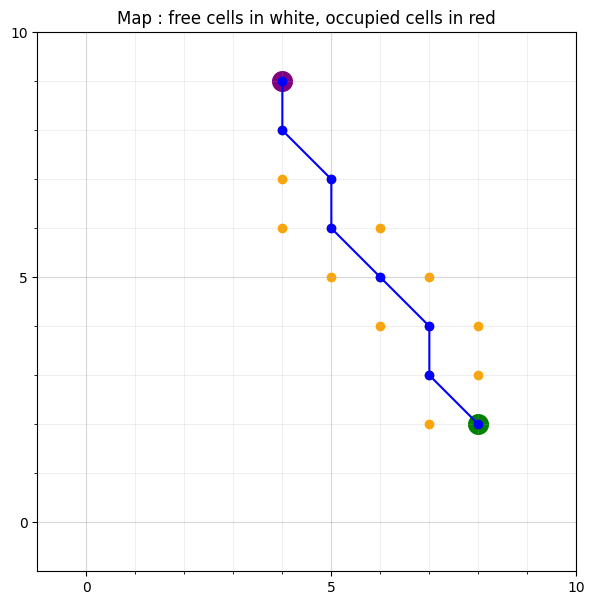

N 8
[788.67028494 235.87104006   3.07917384]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [800, 200]
Theta goal 0.9446496628939673
v,w 10 1.5513161345193787
vr, vl :  306.5004954799235 -239.67010764450382
Z_k  [788.67028494 235.87104006   3.07917384]
St est [788.468336   235.88409271   3.14992878]
k:  1
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 300]
Theta goal 0.49432963611870306
v,w 10 -0.5136375292185552
vr, vl :  -56.484519602421265 124.4980987454118
Z_k  [785.27815468 231.77098696  -2.37841306]
St est [7.85162419e+02 2.32029332e+02 3.80514661e-01]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 300]
Theta goal 0.4708654639126042
v,w 10 -2.1952641442470786
vr, vl :  -352.086921214697 421.0640503047987
Z_k  [781.88602442 227.67093387  -1.80863225]
St est [782.27678155 227.66201588   2.18950354]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 300]
Theta goal 0.4434178164787923
v,w 10 1.8152931697256875
vr, vl :  352.90333239990747 -286.22419993594684
Z_k  [7

KeyboardInterrupt: 

In [3]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 104
R = 20
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 80

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 markers of 4x4 bits.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        # Assign a marker to each objects to be recognized on the map
        # Generate three reference markers
        ref_ids = np.array([0, 1, 2])
        arr = np.zeros([7,7])
        ref_markers = []

        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            ref_markers.append(marker)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

        #map = Map(ref1, ref2, ref3)

        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))

        map = Map(ref1,ref2,ref3,1000,1000)

        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                
                clear_output(wait=True)
                #show_frame(frame)
                new_frame = frame.copy()
                rejectedCandidates = np.array([[]])
                parameters = cv2.aruco.DetectorParameters()
                parameters.adaptiveThreshWinSizeMin = 10
                parameters.adaptiveThreshWinSizeMax = 100
                parameters.adaptiveThreshWinSizeStep = 10
                """ parameters.minMarkerPerimeterRate = 0.03
                parameters.maxMarkerPerimeterRate = 4.0
                parameters.polygonalApproxAccuracyRate = 0.05
                parameters.minCornerDistanceRate = 0.05
                parameters.minDistanceToBorder = 3
                parameters.minMarkerDistanceRate = 0.05
                parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
                parameters.cornerRefinementWinSize = 5
                parameters.cornerRefinementMaxIterations = 30
                parameters.cornerRefinementMinAccuracy = 0.1
                parameters.markerBorderBits = 1
                parameters.perspectiveRemovePixelPerCell = 4
                parameters.perspectiveRemoveIgnoredMarginPerCell = 0.13
                parameters.maxErroneousBitsInBorderRate = 0.04
                parameters.minOtsuStdDev = 60.0
                parameters.errorCorrectionRate = 0.6 """
                detector = cv2.aruco.ArucoDetector(aruco_dictionary, parameters)
                corners, ids, _ = detector.detectMarkers(frame)
                for o in range(np.size(objects,0)):
                    centers = []
                    c = []
                    if np.size(corners,0) > 0:
                        for i in range(np.size(ids,0)):
                            if objects[o].id == ids[i][0]:
                                centers.append(get_center(corners[i][0]))
                                c.append(corners[i][0])
                    objects[o].img_pos = np.array(centers)
                    objects[o].corners = np.array(c)
                ref1.draw(new_frame, [255,0,0])
                ref2.draw(new_frame, [0,255,0])
                ref3.draw(new_frame, [0,0,255])
                show_frame(new_frame)
                if (np.size(ref1.img_pos,0) > 0) and (np.size(ref2.img_pos,0) > 0) and (np.size(ref3.img_pos,0) > 0):
                    matrix = map.matrix(frame,[],thymio,goal)
                    print('Thymio map pos', map.localize(frame, thymio))
                    if(np.size(thymio.get_img_dir(), 0)> 0):
                        print('Thymio map dir', vector_to_angle(thymio.get_img_dir()[0]))

                    if check_matrix(matrix):
                        #path = global_path(matrix)
                        
                        max_val_x, max_val_y, start, end, arr = conversion(matrix)
                        h, coords = heuristics(max_val_x, max_val_y, end)
                        path, visitedNodes = A_Star(start, end, h, coords, arr, max_val_x, max_val_y)
                        path = np.array(path).reshape(-1, 2).transpose()
                        visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
                        cmap = colors.ListedColormap(['white', 'red'])
                        # Displaying the map
                        fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
                        ax_astar.imshow(arr.transpose(), cmap)

                        # Plot the best path found and the list of visited nodes
                        ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
                        ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
                        ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
                        ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200)
                        plt.title("best path in blue, visited nodes in orange")
                        plt.title("Map : free cells in white, occupied cells in red")
                        plt.show()
                        path = np.multiply(path, 100)
                        N = np.size(path,1)
                        print("N" ,N)
                        path_found = True
                        state_estimate_k = np.array([map.localize(frame,thymio)[0][0],map.localize(frame,thymio)[0][1],vector_to_angle(thymio.get_img_dir()[0])])
                        print(state_estimate_k)

        # Navigation
        state = 1    
        # Global navigation state
        if state == 1:

            while not_arrived == True:
                #Check if there is obstacles
                prox_horizontal = local.read_prox_sensors(node,client)
                obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
                print("obstacles",obst)
                state = local.update_state(state,obst,client)

                # Update temporary goal
                print("Pth", [path[0,k],path[1,k]])
                if k < N-1:
                    theta_goal_temp = (math.atan2(path[1,k+1]-state_estimate_k[1], path[0,k+1]-state_estimate_k[0]) + np.pi) % (np.pi/2)
                    print('Theta goal',theta_goal_temp)
                v, w = mctrl.control_law(state_estimate_k, path[0,k], path[1,k], theta_goal_temp)
                print("v,w",v,w)
                vr, vl = mctrl.convert_velocity2RL(v,w,C_conv_toThymio_right, C_conv_toThymio_left,L,R)
                print("vr, vl : ",vr,vl)
                vr = int(vr)
                vl = int(vl)
                mctrl.set_motors(vl,vr,node)
                
                camera_obstructed = 1
                # Check if camera is obstructed
                if video.isOpened:
                    ret, frame = video.read()
                    new_frame = frame.copy()
                    if ret == True:
                        #clear_output(wait=True)
                        corners, ids, _ = detector.detectMarkers(frame)
                        for o in range(np.size(objects,0)):
                            centers = []
                            c = []
                            if np.size(corners,0) > 0:
                                for i in range(np.size(ids,0)):
                                    if objects[o].id == ids[i][0]:
                                        centers.append(get_center(corners[i][0]))
                                        c.append(corners[i][0])
                            objects[o].img_pos = np.array(centers)
                            objects[o].corners = np.array(c)
                        """ ref1.draw(new_frame, [255,0,0])
                        ref2.draw(new_frame, [0,255,0])
                        ref3.draw(new_frame, [0,0,255])
                        goal.draw(new_frame, [255,255,255])
                        thymio.draw(new_frame, [255,100,100])
                        show_frame(new_frame) """
                        z_k_observation_vector = np.array([state_estimate_k[0], state_estimate_k[1], state_estimate_k[2]])
                        if (np.size(ref1.img_pos,0) > 0) and (np.size(ref2.img_pos,0) > 0) and (np.size(ref3.img_pos,0) > 0):
                            if np.size(map.localize(frame,thymio), 0) > 0:
                                camera_obstructed = 0
                                #print('Path :', path)
                                z_k_observation_vector = np.array([map.localize(frame,thymio)[0][0],map.localize(frame,thymio)[0][1],vector_to_angle(thymio.get_img_dir()[0])]) 
                                print("Z_k ", z_k_observation_vector)
                                P_k_minus_1 = P_k
                                state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                                print("St est", state_estimate_k)
                        state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                    k = k+1
                    print("k: ", k)
                    if k == N-1:
                        not_arrived = False
                        print('The robot has arrived to the final goal')
                        mctrl.stop_motors(node)

                        break 
                time.sleep(Ts)
            state = 3                                               


        # Local navigation state
        if state == 2: 
            print("Local activated")
            
            #We get the sensor value
            prox_horizontal = local.read_prox_sensors(node,client)
            
            #We fill the obst list with the sensor value
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            
            #We calculate the motor speed to avoid the object -> potential field method
            motors_speed = local.local_navigation(obst)
            
            #We set the motor speed
            mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
            
            #We update the state
            state = local.update_state(state,obst,client)   


In [ ]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [4]:
mctrl.stop_motors(node)